<a href="https://colab.research.google.com/github/NailaImran/learn-generative-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-1/5_agent_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [6]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph langchain_community tavily-python

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY,
    temperature=0
)
result  = llm.invoke("Who won 2024 US presidential ellection?")
result


AIMessage(content='The 2024 US presidential election has not yet happened.  The election will be held in November 2024.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5dc648ab-2250-46c4-82a0-092ff3b158f7-0', usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42, 'input_token_details': {'cache_read': 0}})

In [8]:
import os
from google.colab import userdata
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("Who won 2024 US presidential ellection?")
search_docs

[{'url': 'https://www.bbc.com/news/election/2024/us/results',
  'content': 'US Presidential Election Results 2024 - BBC News Close menu BBC News Kamala Harris of the Democrat party has 0 electoral college votes. Donald Trump of the Republican party has 0 electoral college votes. Kamala Harris of the Democrat party has 158,810 votes (38.4%) Donald Trump of the Republican party has 249,225 votes (60.2%) US presidential election results 2024 US election 2024 Voting in some states is particularly hard to predict, with polls showing they could be won by the Republicans or the Democratic party. The battleground states that could decide the 2024 presidential election are: Voters in 11 states will also elect a governor. US election polls: Who is ahead - Harris or Trump? US election 2024 About the BBC'},
 {'url': 'https://www.cnn.com/election/2024/results/president',
  'content': "Presidential election results 2024 | CNN Politics CNN10 About CNN Watch CNN CNN Harris is hoping to become the firs

In [9]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [10]:
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('lang-graph')

This follows what we did previously.

In [24]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)
llm_with_tools = llm.bind_tools(tools)
#tool.invoke("Guide me what type of dress should I wear in office party?")


In [47]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked to help people to choose their out fit according to the event.Ask the user about his or her age gender and region for best recommendation.")

# Node
def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

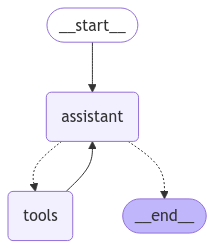

In [49]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [50]:
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()
react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

In [51]:
# Specify a thread
config1 = {"configurable": {"thread_id": "1"}}


In [52]:


# Specify an input
messages = [HumanMessage(content="What dress should I wear in office party?")]
messages = [HumanMessage(content="My age is 38")]
messages = [HumanMessage(content="My gender is male")]
messages = [HumanMessage(content="My region is USA")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

My region is USA
================================== Ai Message ==================================

Great!  And what is your age range and gender?  This will help me give you more relevant outfit recommendations.


If we pass the same `thread_id`, then we can proceed from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `agent` in the UI, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.